In [1]:
%pylab inline
import stpsf, astropy

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# JWST Using Wavefronts Measured On Orbit


STPSF now includes code for using the results of in-flight wavefront sensing measurements, by retrieving Optical Path Difference (OPD) files which include the sensing results for the positions of the mirrors at different times. These are produced by the JWST Wavefront Sensing Subsystem (WSS), using focus diverse phase retrieval on NIRCam weak lens data taken roughly every two days in flight. The output OPDs from that are saved in MAST and can be automatically retrieved and used in STPSF. 

These can be used to: 
- Produce PSFs which are matched to the measured telescope state on a given time
- Trend and monitor telescope stability over time, including for time periods around particular observations
- Retrieve the JWST wavefront sensing measurements themselves for additional analyses, if desired. 


## Generating PSFs using measured wavefronts

### Finding the measured wavefront near a given date

Begin by instantiating an instrument instance in the usual manner. In this case, let's set up a NIRCam instance for one of the detectors in module B. 

In [2]:
nrc = stpsf.NIRCam()
nrc.filter='F200W'

nrc.detector = 'NRCB2'
nrc.detector_position = (1024,1024)

To load an OPD corresponding to observations on some particular date, use the method `load_wss_opd_by_date`. This takes as its first argument a date time specified in ISO format, like "YYYY-MM-DDTHH:MM:SS".  

Let's also set `plot=True` so this makes a plot which shows what's going on.


MAST OPD query around UTC: 2022-07-01T00:00:00.000
                        MJD: 59761.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022063002-NRCA3_FP1-2.fits
	Date (MJD):	 59759.6628
	Delta time:	 -1.3372 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022070403-NRCA3_FP1-0.fits
	Date (MJD):	 59761.5484
	Delta time:	 0.5484 days
User requested choosing OPD time closest in time to 2022-07-01T00:00:00.000, which is R2022070403-NRCA3_FP1-0.fits, delta time 0.548 days
Importing and format-converting OPD from /Users/mperrin/software/stpsf-data/MAST_JWST_WSS_OPDs/R2022070403-NRCA3_FP1-0.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


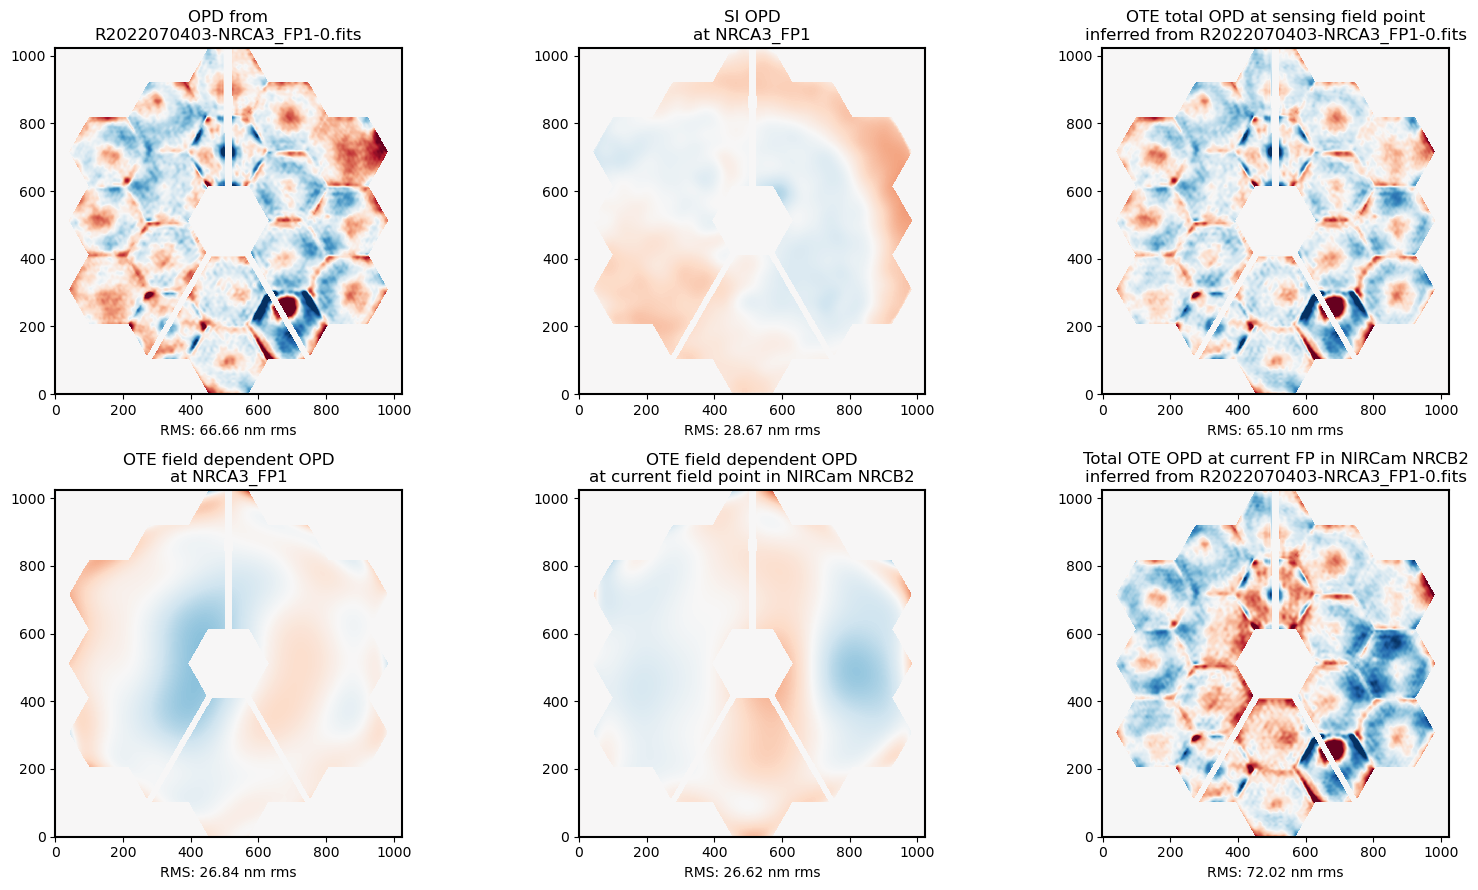

In [3]:
nrc.load_wss_opd_by_date('2022-07-01T00:00:00',plot=True)

Given the input date, the function queries to find the closest-in-time wavefront sensing result. In this case it is a measurement about 0.5 days after the specified time. (You can set keyword `choice='before'` or `choice='after'` if you have some reason to specify which in particular).  That OPD file will be automatically retrievd from MAST; downloads are cached inside your $STPSF_DATA_PATH directory for reuse in multiple calculations.

Let's look at each plot in turn. 

* **Upper Left:** This is the measured OPD as sensed in NIRCam at "field point 1" which is in the upper left corner of NRCA3, relatively close to the center of the NIRCam module. This observatory total OPD measurement includes both the telescope and NIRCam contributions to the WFE.
* **Upper Middle:** This is the wavefront map for the NIRCam portion of the WFE at that field point. This is known from ground calibration test data, not measured in flight. 
* **Upper Right:** That NIRCam WFE contribution is subtracted from the total observatory WFE to yield this estimate of the OTE-only portion of the WFE.
* **Lower Left and Middle:** These are models for the field dependence of the OTE OPD between the sensing field point in NRCA3 and the requested field ooint, in this case in NRCB2. This field dependence arises mostly from the figure of the tertiary mirror. These are used to transform the estimated OTE OPD from one field position to another. 
* **Lower Right**: This is the resulting estimate for the OTE OPD at the requested field point, in this case in NRCB2. 

All those calculations happen automatically as part of the `load_wss_opd_by_date` (inside the `load_wss_opd` function which it calls in turn). 

We note that the function `setup_sim_to_match_data`  ([documented here](https://stpsf.readthedocs.io/en/latest/jwst_matching_psfs_to_data.html)) provides a succinct way to automate the above steps of creating an instrument model and loading a wavefront OPD. 

After that it's just a matter of calculating PSFs as usual: 

In [4]:
psf = nrc.calc_psf(fov_pixels=101)

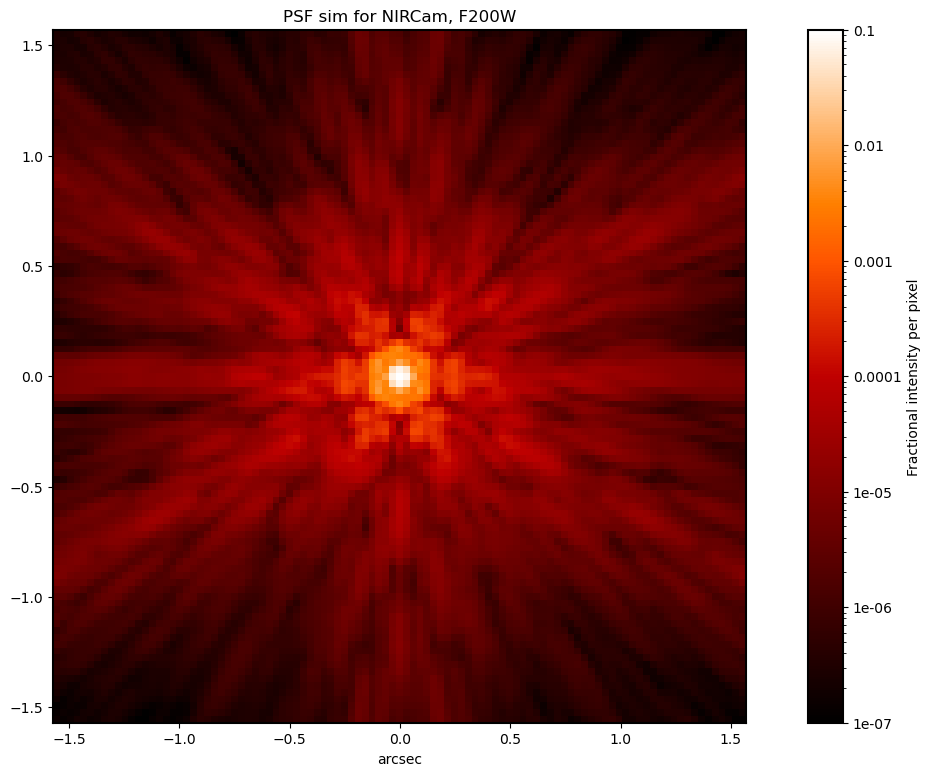

In [5]:
plt.figure(figsize=(16,9))
stpsf.display_psf(psf, ext=1)

Thus, the above PSF is calculated using the actual as-measured-at-L2 state of the telescope WFE near the requested date, in this case 2022 July 1. 

### Loading a particular OPD file

If you already know the filename of a particular desired OPD file, you can simply retrieve it by name using the `load_wss_opd` function. Once again, this file will be automatically retrieved from MAST if necessary. 

Found OPD file previously downloaded: O2022073001-NRCA3_FP1-1.fits
Importing and format-converting OPD from /Users/mperrin/software/stpsf-data/MAST_JWST_WSS_OPDs/O2022073001-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


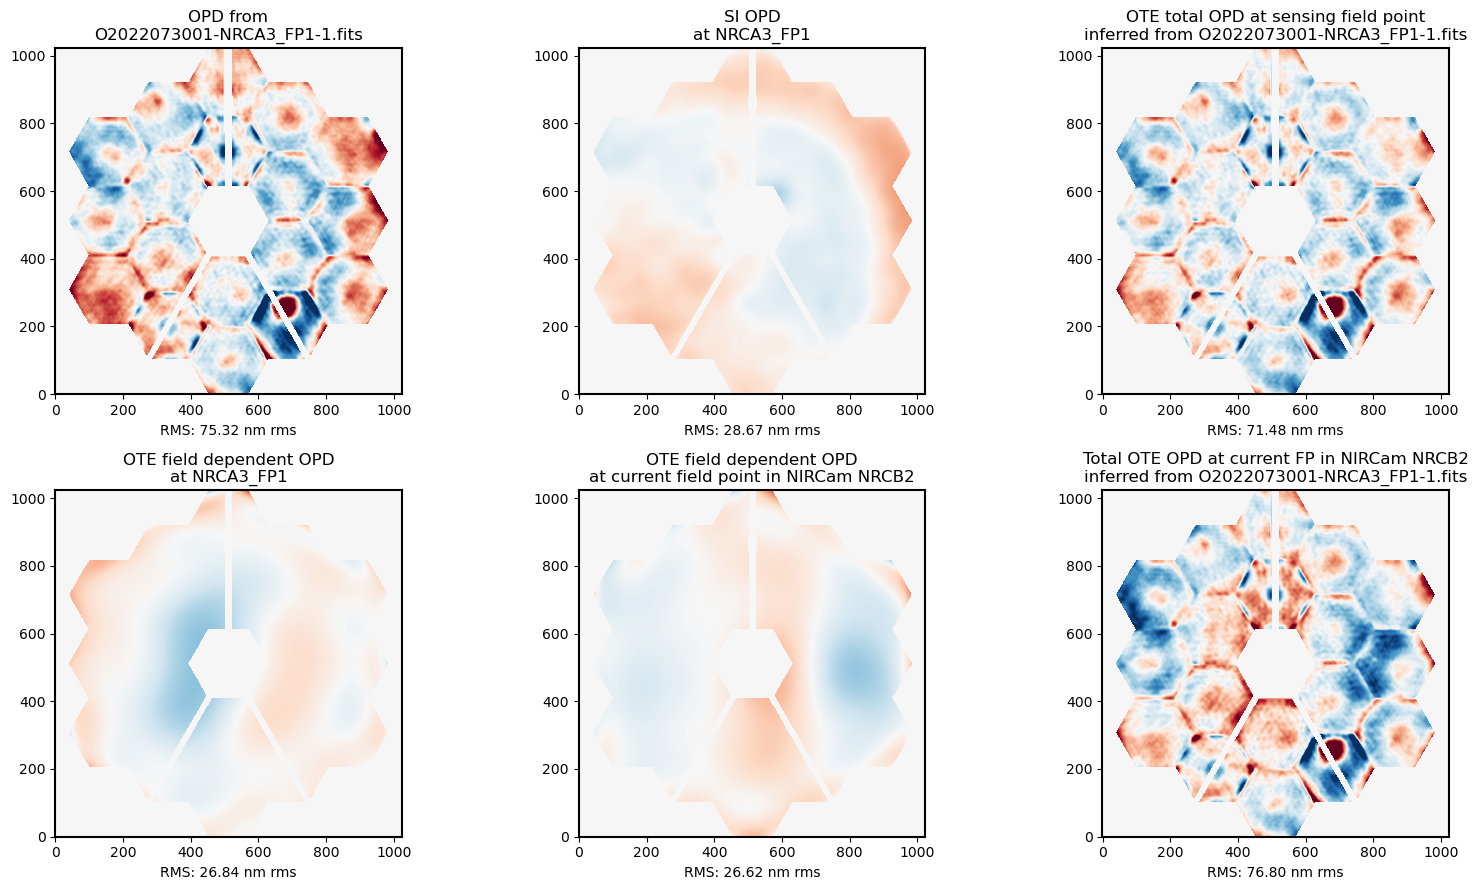

In [6]:
nrc.load_wss_opd("O2022073001-NRCA3_FP1-1.fits", plot=True)

## Trending Wavefront Changes over Time

To help observers understand how the mirror alignments change over time, and when such changes might affect  PSFs in science data, STPSF also includes some functions for generating trending plots showing wavefronts over time. 

These functions work by downloading sets of several OPDs from MAST, and performing calculations such as inferring the changes between one measurement and the next. 


### Wavefront Trending throughout a given month

A wavefront trending plot can be produced that shows wavefront changes during some particular month of interest:

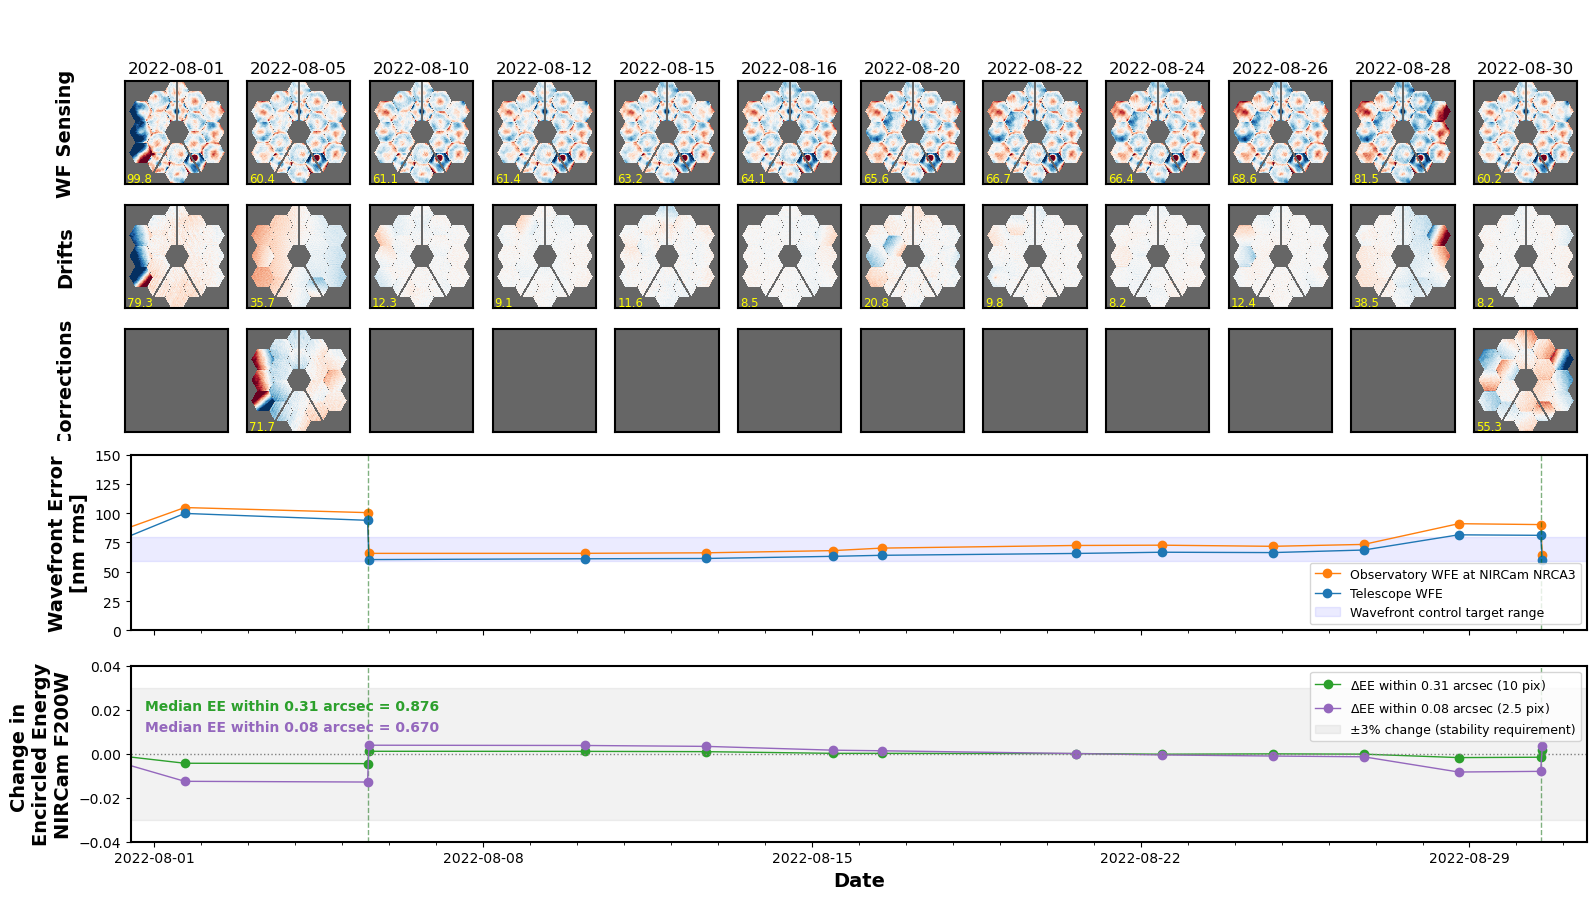

In [7]:
trend_table = stpsf.trending.monthly_trending_plot(2022, 8, verbose=False)

The above figure shows: 

 * Each wavefront sensing measurement throughout the specified month (first row)
 * The drift in wavefront between each two successive measurements (i.e. the changes arising in the telescope itself, without any ground commanding. Second row)
 * The mirror corrections applied (i.e. the result of mirror move commands sent from the ground. Third row)
 * Plots of the wavefront RMS value over time, for both the OTE wavefront only (i.e. the waveront quality from the telescope delivered to the NIRCam sensing field point) and the total observatory wavefront (i.e. the sum of telescope and instrument contributions to the wavefront). 
 * Computed values for the encircled energy within radii of 2.5 pixels and 10 pixels, and their variation over time. 
 
In the above plot for 2022 July, we can see that the wavefront was generally stable (very little change from one meaurement to the next, but a few individual mirror tilt events can be seen for instance in the July 4 and July 6 sensing). A wavefront correction was applied on July 8. Then the July 12 wavefront sensing revealed a  larger wing tilt event affecting the several segments on the left (-V2) wing. This was corrected in the July 15 wavefront sensing and control observation, and after that the telescope remained stable throughout the rest of that month's wavefront sensing. 

The `monthly_trending_plot` function automatically saves the plot as a PDF to the current working directory, with filenames like "`wf_trending_2022-08.pdf'`"


The function also returns a table with information summarizing the available WFS measurements, WFE levels, and computed PSF encircle energies. This can be used to help understand how much the photometry in your observation is affected by PSF changes at a given time. 

In [8]:
trend_table

<QTable length=15>
          Date                    Filename           ...     EE(10pix)     
                                                     ...                   
         str23                     str29             ...      float64      
----------------------- ---------------------------- ... ------------------
2022-07-30T14:16:12.800 O2022073001-NRCA3_FP1-1.fits ... 0.8767156339082203
2022-08-01T15:29:51.000 R2022080204-NRCA3_FP1-0.fits ...  0.871685491787062
2022-08-05T12:55:58.900 R2022080601-NRCA3_FP1-0.fits ... 0.8715130503124521
2022-08-05T13:38:34.300 R2022080601-NRCA3_FP1-1.fits ... 0.8771249633140422
2022-08-10T04:06:35.800 R2022081102-NRCA3_FP1-1.fits ... 0.8770853234542049
2022-08-12T17:58:37.000 O2022081401-NRCA3_FP1-1.fits ... 0.8769571339901217
2022-08-15T10:41:30.900 O2022081601-NRCA3_FP1-1.fits ... 0.8761902354255183
2022-08-16T11:38:59.500 O2022081602-NRCA3_FP1-1.fits ...   0.87618409429269
2022-08-20T14:48:34.300 R2022082003-NRCA3_FP1-1.fits ... 0.8760920643391353
2022-08-22T10:53:59.300 R2022082202-NRCA3_FP1-1.fits ... 0.8757979843558308
2022-08-24T19:21:06.100 R2022090101-NRCA3_FP1-2.fits ... 0.8759543259835378
2022-08-26T17:58:13.600 R2022082702-NRCA3_FP1-1.fits ... 0.8758259956765841
2022-08-28T18:26:59.700 R2022082903-NRCA3_FP1-0.fits ... 0.8742555503448957
2022-08-30T12:22:42.100 R2022090102-NRCA3_FP1-1.fits ... 0.8744257093115919
2022-08-30T13:11:54.700 R2022083109-NRCA3_FP1-1.fits ... 0.8778265977632995

By default, the trending table performs computations of the encircled energy for NIRCam F200W, but you can specify a different instrument and filter if so desired. 

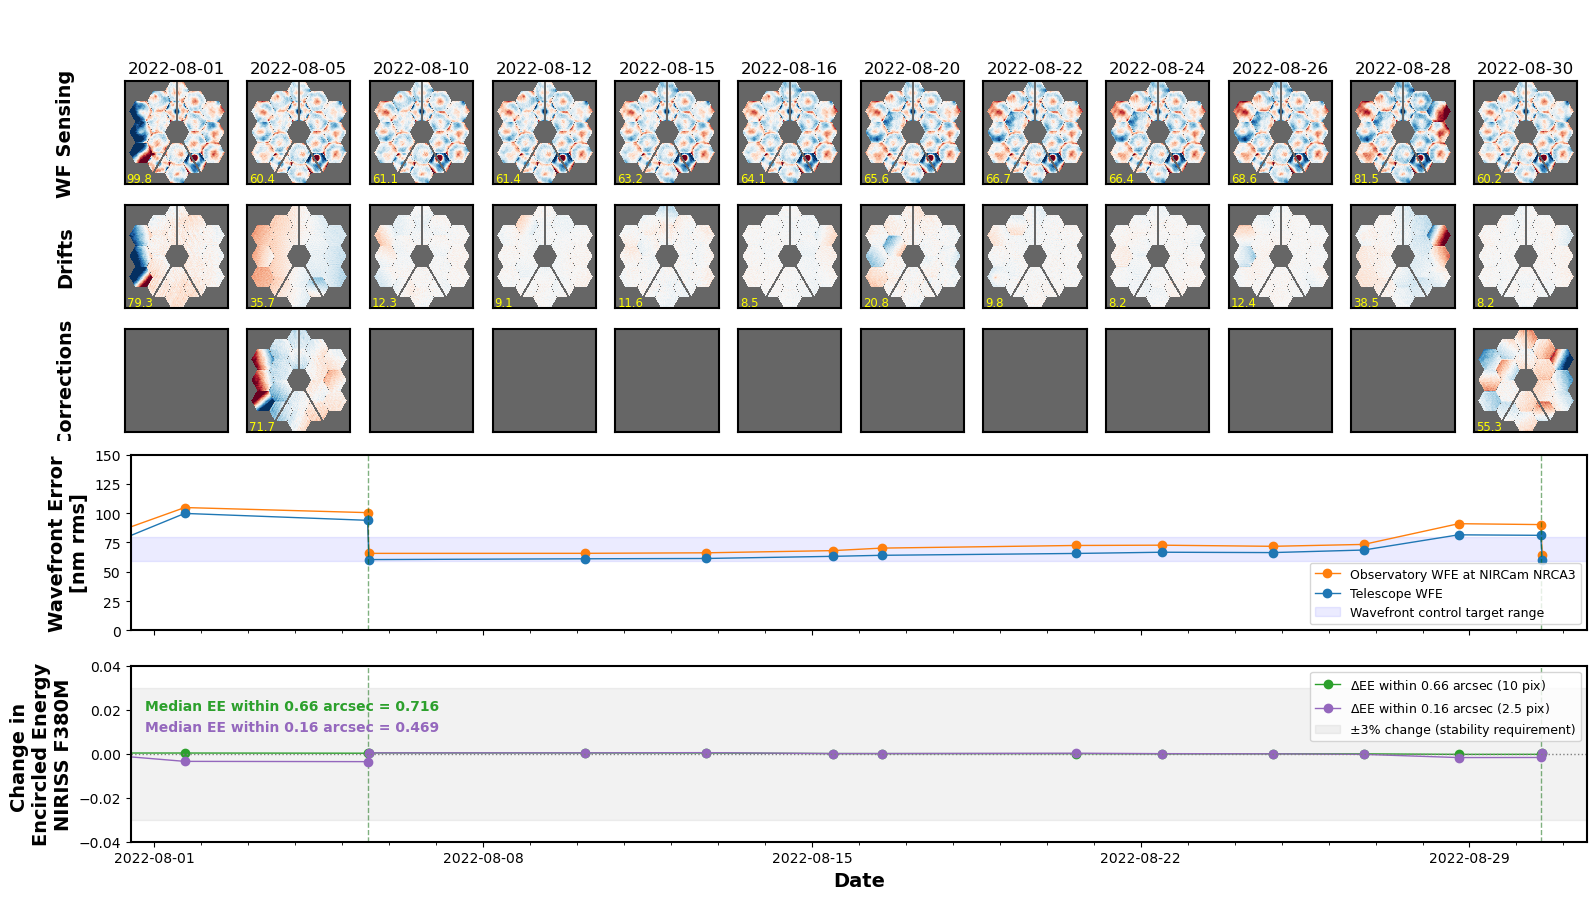

In [9]:
stpsf.trending.monthly_trending_plot(2022, 8, verbose=False, instrument='NIRISS', filter='F380M'); 

### Checking wavefront sensing results around particular science observations

These functions allow checking telescope sensing results around a particular observation, or for all observations in a given program. 

Here, we check the wavefront stability around one of the exposures from the cycle 1 deep-field program JADES:


File jw01180026001_07201_00002_nrca3_cal.fits observed at 2022-10-07T23:43:22.581
Retrieving WFS before that obs... WFS at 2022-10-06T08:29:18.829
Retrieving WFS after that obs... WFS at 2022-10-08T10:22:06.398


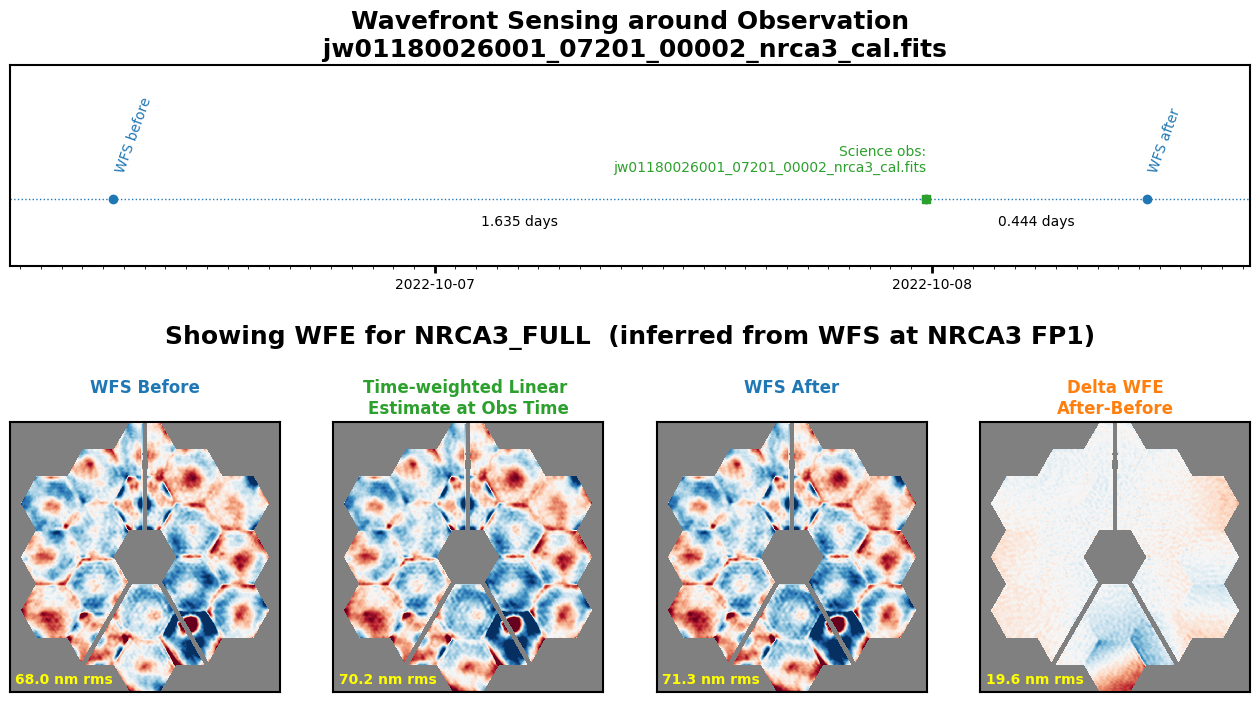

In [3]:
stpsf.trending.show_wfs_around_obs('jw01180026001_07201_00002_nrca3_cal.fits')

The top panel shows a timeline, indicating the time separation of that particular science observation relative to the roughly-every-2-days wavefront sensing programs. (This plot is always a horizontal line, just showing time spans; the vertical axis doesn't indicate anything.) The wavefront sensing measurements before and after are shown below, and their difference. In this case, we see there was a moderate motion of a few segments near the bottom side of the OTE, but at a level which is small enough to probably not affect science performance significantly. 


We can also check the wavefront variations over time for all observations in a given program. This can help inform on how carefully it might be needed to consider variations in PSFs or encircled energy during science analyses. 

Let's check the telescope stability for all the JADES observations in cycle 1:

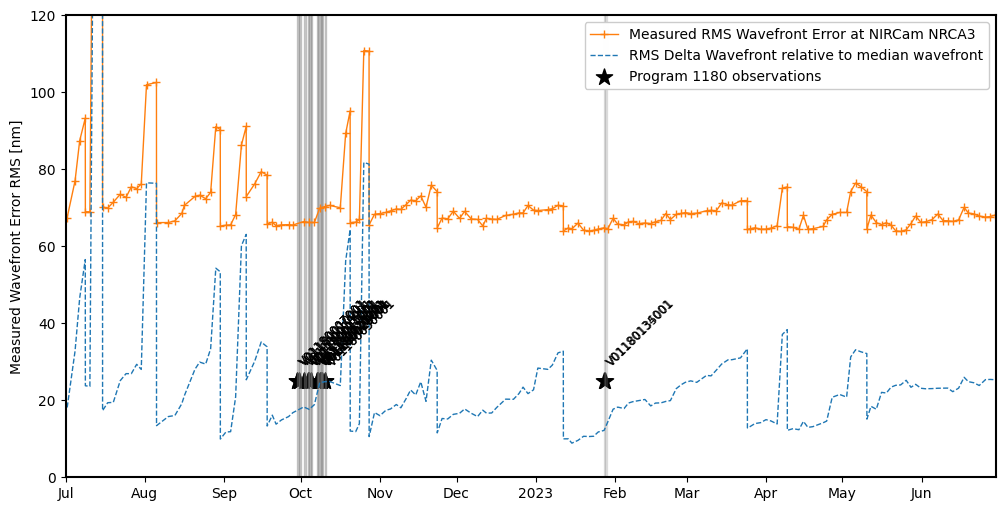

In [2]:
stpsf.trending.show_wfs_during_program(1180, start_date='2022-07-01', end_date = '2023-06-30')

The stars with text labels and gray vertical lines indicate the times of all observations in that program. (There's a lot of observations in October so the labels are a bit hard to read in this case.) We  can see that, while the telescope had occasional periods of higher wavefront error, all of the JADES observations happened with the telescope wavefront error around its typical value. 

The orange line shows the measured total wavefront RMS for each sensing; the blue line shows the RMS difference at each time relative to the median wavefront. In this case, all the JADES observations happened with no more than about 20 nm rms wavefront differences relative to the mean; this is lambda/100 at 2 microns, for instance, which leads to quite stable PSFs. 

## Wavefront time series and histogram plots

Other functions can provide views of wavefront changes over even longer timescales. We can retrieve a table of all available OPDs and plot the measurements over time:

In [2]:
opdtable = stpsf.mast_wss.retrieve_mast_opd_table()
opdtable = stpsf.mast_wss.deduplicate_opd_table(opdtable)
stpsf.mast_wss.download_all_opds(opdtable)

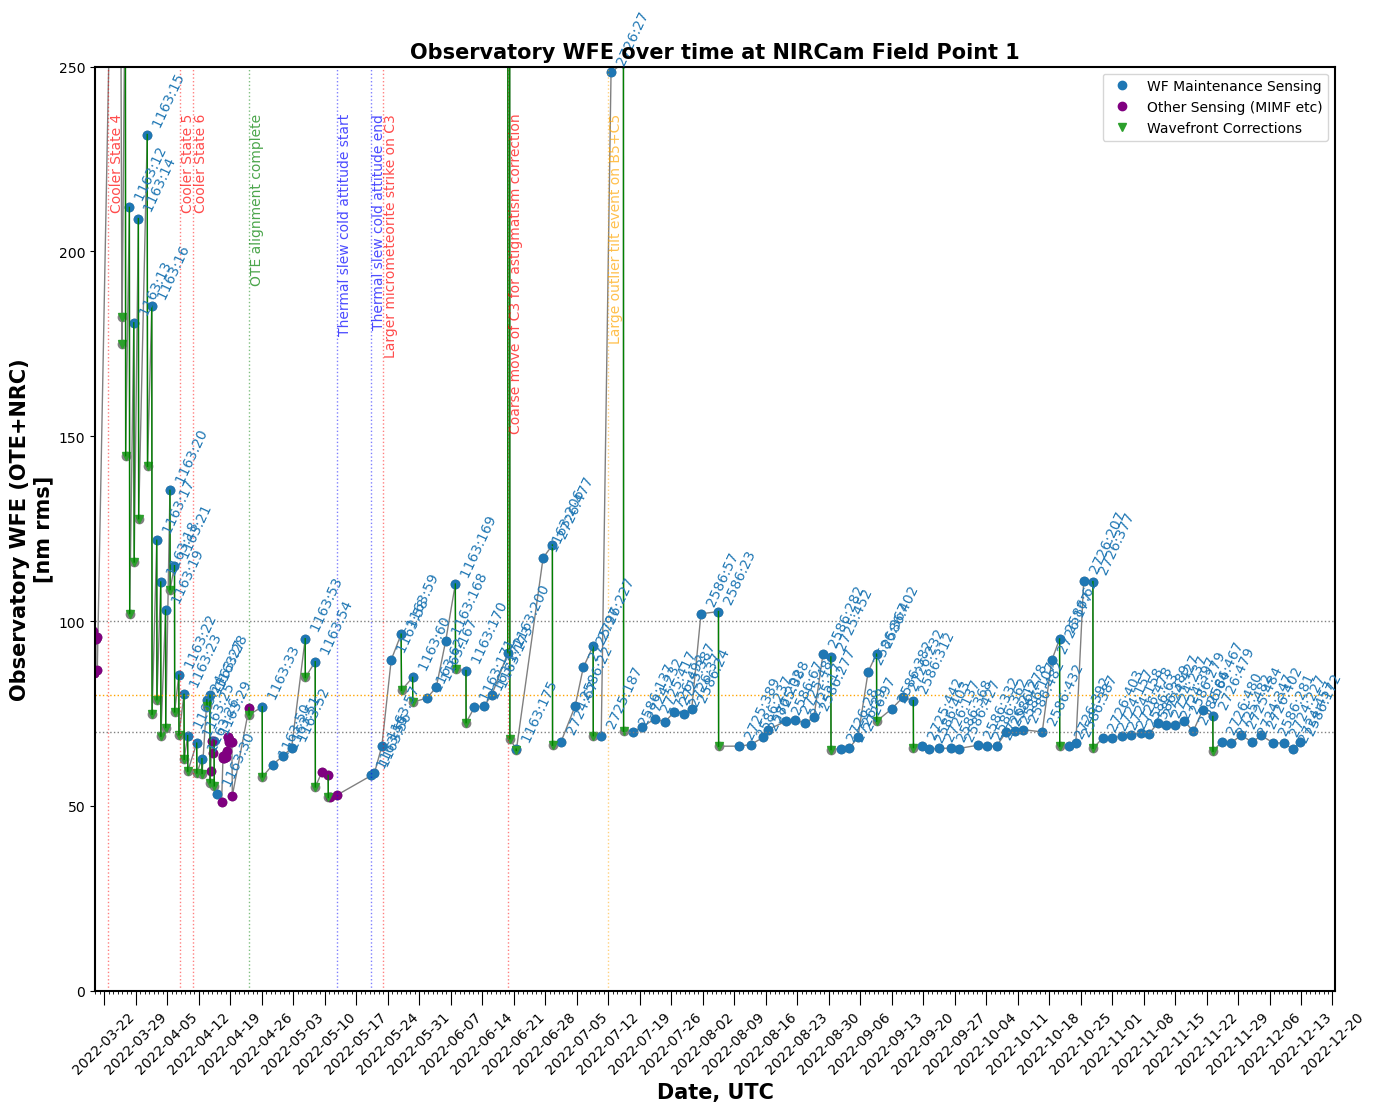

In [3]:
stpsf.trending.wavefront_time_series_plot(opdtable)

The above shows wavefront drifts and corrections from around the middle of OTE commissioning to the early part of Cycle 1.  Rapid drifts and corrections in early March are from the MIRI cryocooler gradually cooling the observatory, until reaching thermal stability in mid April. 

Occasional increases in wavefront error from mirror tilts and corrections can be seen in subsequent months.  There was an especially large tilt event on July 12, which was corrected on July 15. 

We can also plot all measured wavefront drifts over specified time periods. 

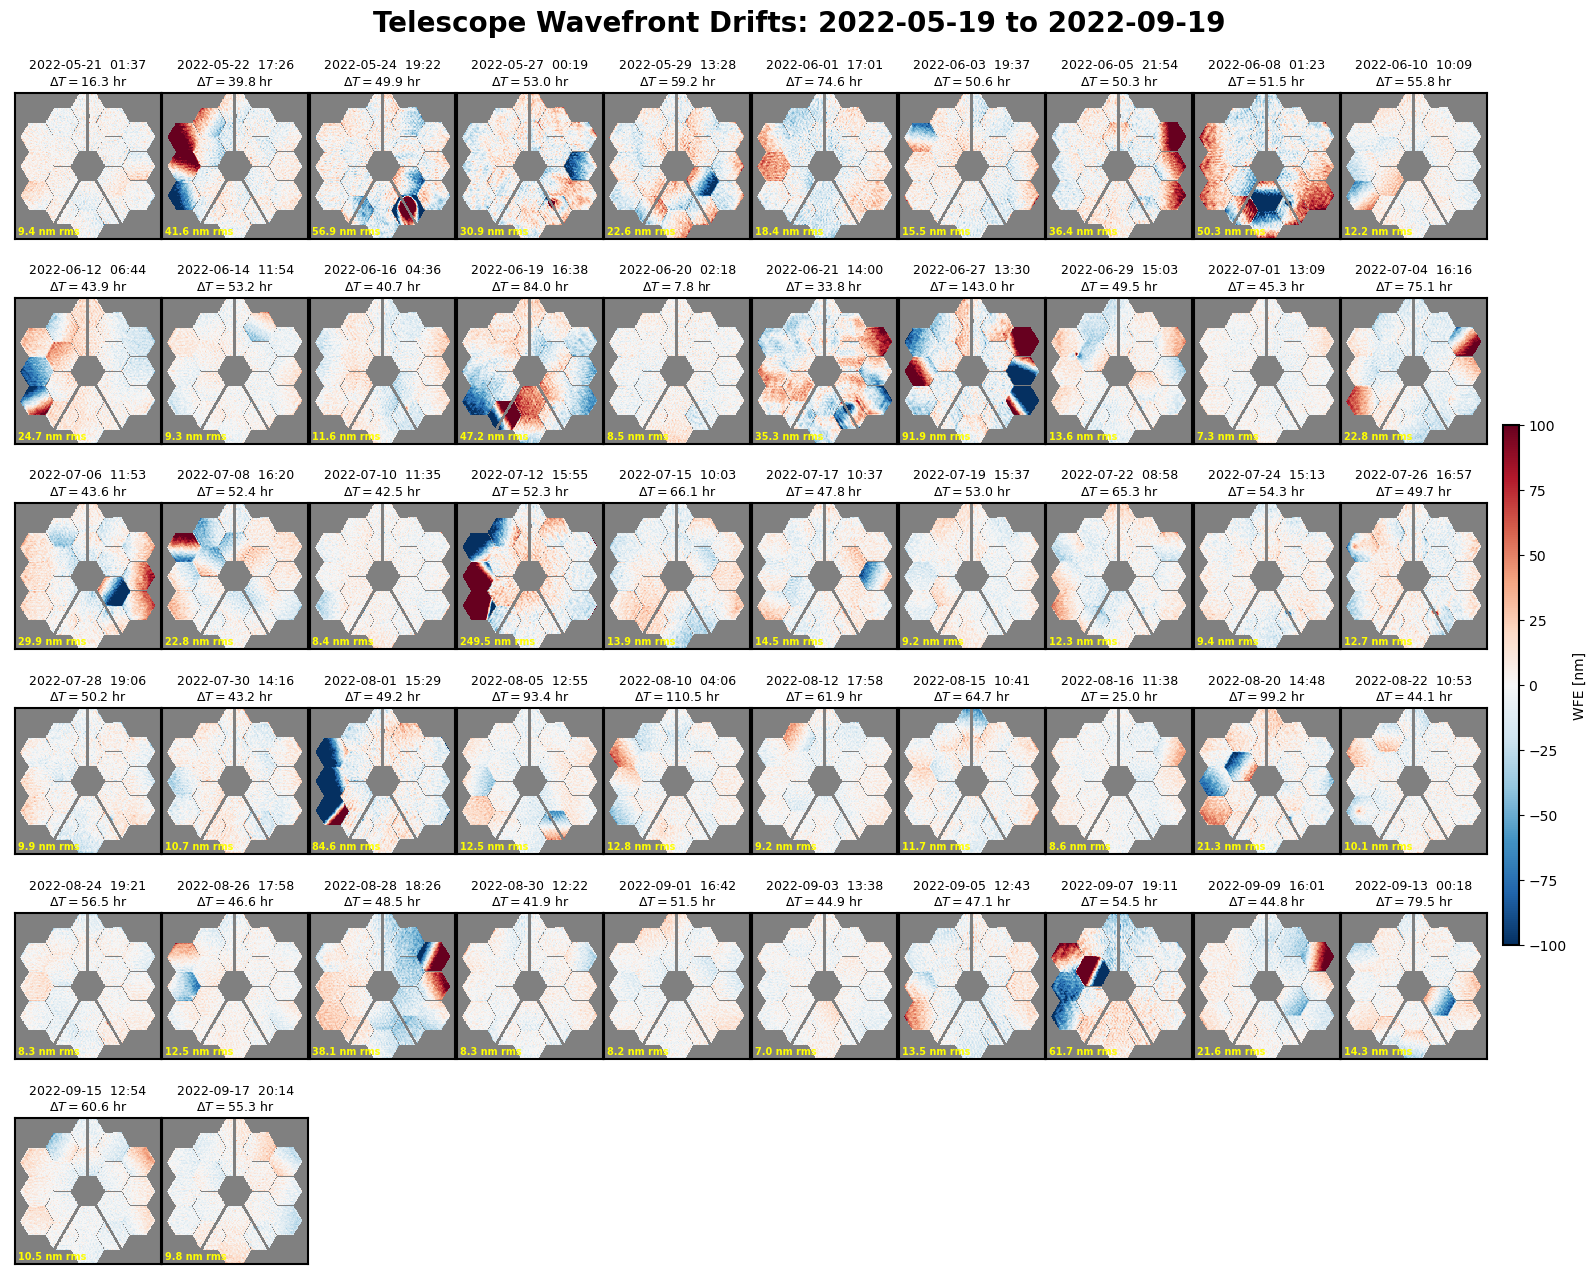

In [4]:
start_time =  astropy.time.Time('2022-05-19T00:00:00')
end_time = astropy.time.Time('2022-09-19T00:00:00')

stpsf.trending.wavefront_drift_plots(opdtable, start_time=start_time, end_time=end_time, n_per_row=10)

Lastly, we can plot histograms of wavefront error levels over time.

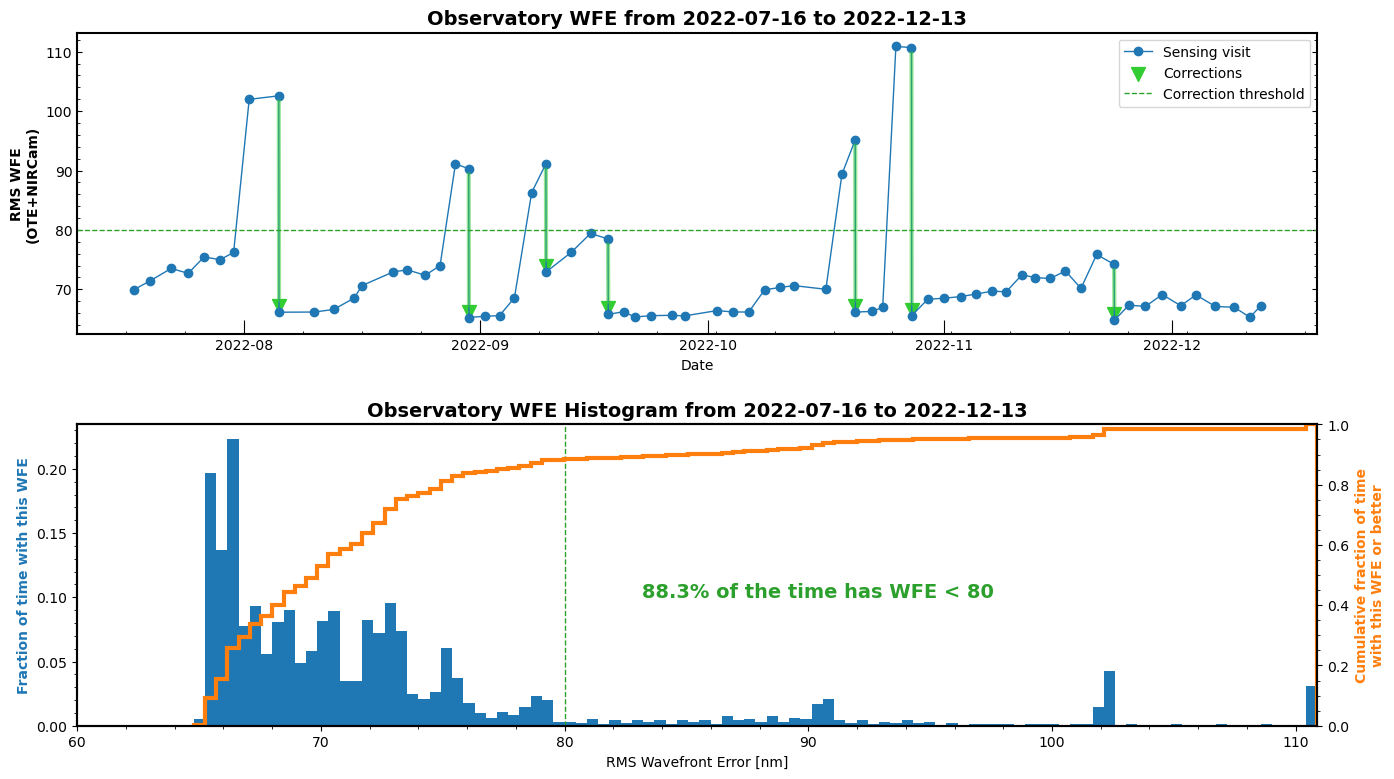

In [5]:
start_time =  astropy.time.Time('2022-07-16')
stpsf.trending.wfe_histogram_plot(opdtable, thresh=80, mark_corrections='arrows')

The above plot shows the wavefront error evolution over the first part of Cycle 1, starting after the ERO release on July 12 and continuing up to present (as of 2022 Dec 13, during the "First Science with JWST" conference). You can see the occasional larger tilt events which are subsequently detected and corrected. It appears possible that the frequency of the larger events may be decreasing over time.

## Viewing wavefront observation data and deltas

In addition to the derived wavefront maps, the OPD data files in MAST contain FITS extensions with the image data from the wavefront sensing measurements, with cutouts of the weak lens sensing data. (The full images are also separately available from MAST too). Although most users will not need to refer to these, STPSF includes display tools for viewing them, for instance to help cross-check the quality of a particular wavefront retrieval. 


The function `plot_phase_retrieval_crosscheck` shows the measured weak lens data (left column), and the models of these produced by the Wavefront Analysis Software during the phase retrieval analyses (middle column). 


<Figure size 640x480 with 0 Axes>

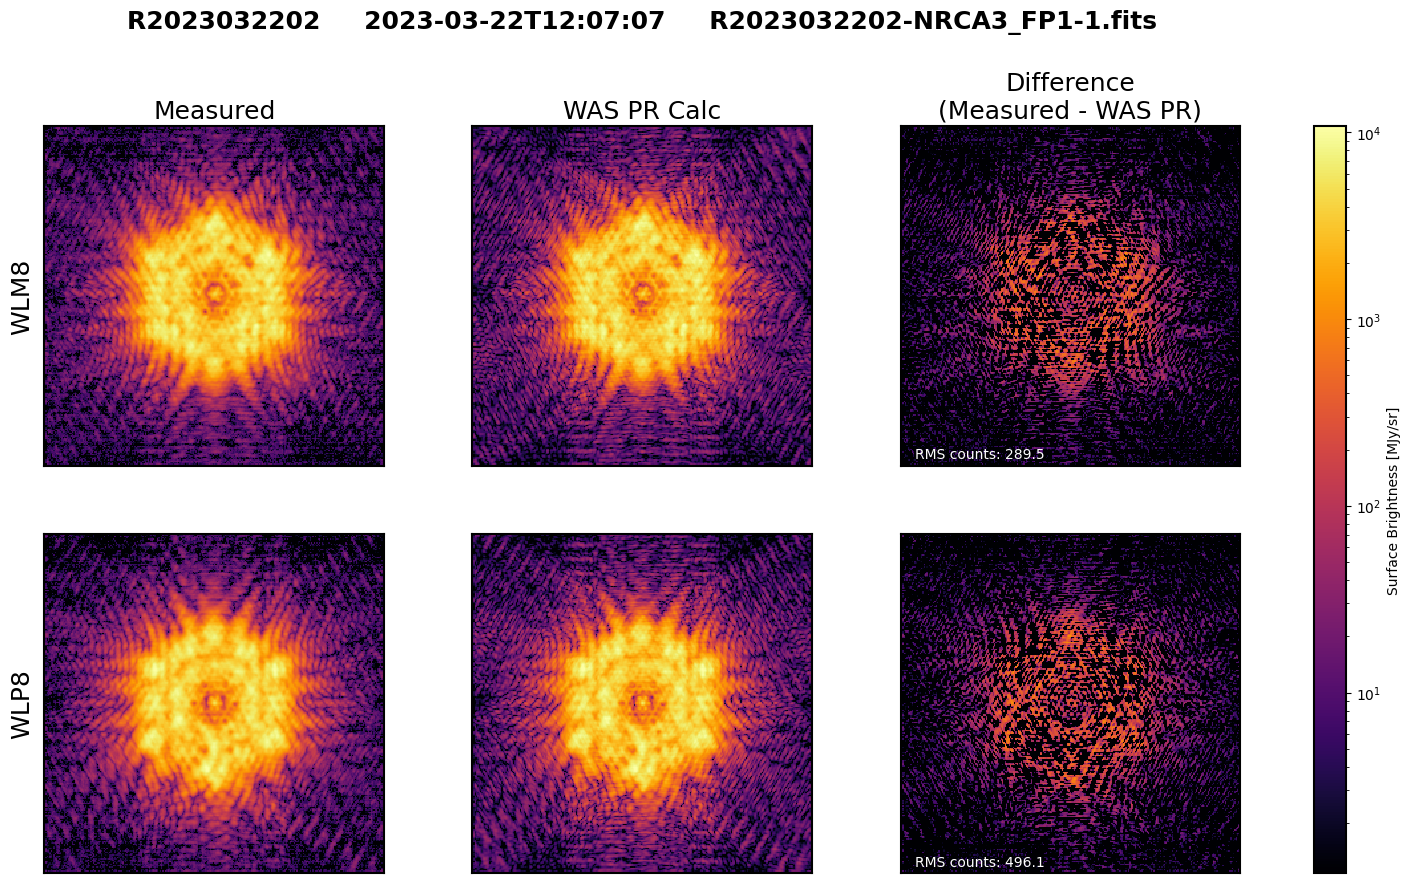

In [3]:
most_recent_wfs_file = opdtable[-1]['fileName']

stpsf.trending.plot_phase_retrieval_crosscheck(most_recent_wfs_file);

The function `plot_wfs_obs_delta` plots the difference of two (probably successive) WFS observations. This can be a useful way to quickly visualize what changed from one observation to another, including the presence of potential spoilers such as binary companions. 

Here's an example of that from WF sensing in January 2023. The presence of a binary companion shows up clearly in the difference image.  


<Figure size 640x480 with 0 Axes>

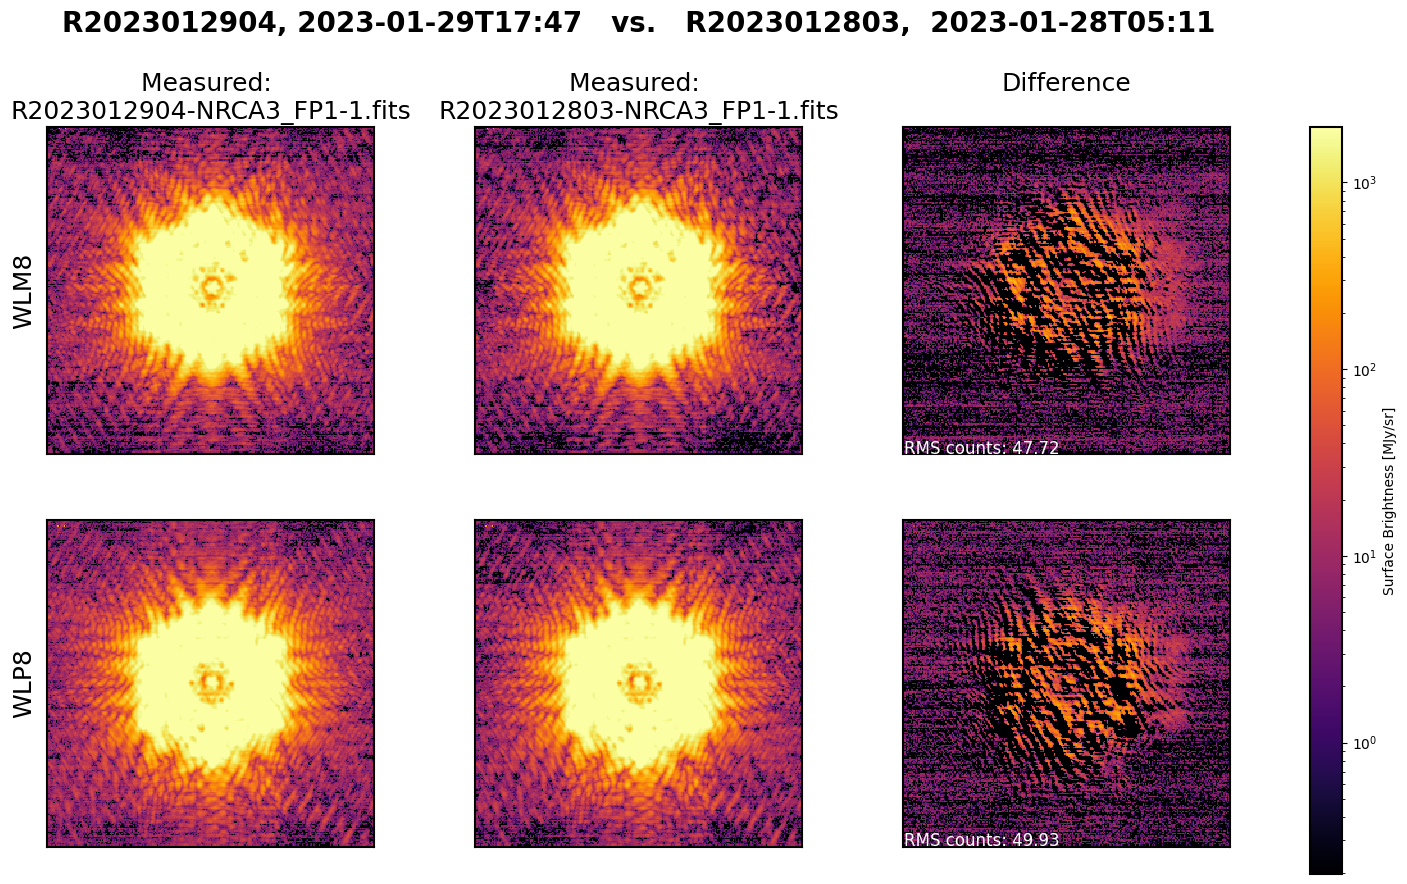

In [4]:
stpsf.trending.plot_wfs_obs_delta('R2023012904-NRCA3_FP1-1.fits', 'R2023012803-NRCA3_FP1-1.fits', 
                                    vmax_fraction=0.2);